# Install the dependencies

In [3]:
pip install virtualenv

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install -r https://raw.githubusercontent.com/NeloyNSU/Face-Mask-Detection-in-Web-Browser/master/requirements.txt

# Train the face mask detector model

## Preprocess the dataset

In [7]:
# Get the images data

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from imutils import paths
import os

data = []
labels = []

DATA_PATH = "../data"
image_path_list = list(paths.list_images(DATA_PATH))

for image_path in image_path_list:
    # extract the class label from the filename
    label = image_path.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

E:\Anaconda\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
# Convert the images and labels to NumPy array

import numpy as np

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
# Perform one-hot encoding on the labels

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
# Partition the data into training and testing

from sklearn.model_selection import train_test_split

TEST_SIZE = 0.25
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=TEST_SIZE, stratify=labels, random_state=42)

## Build and train the model

In [11]:
# Construct the training image generator for data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [12]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 6s 1us/step


In [13]:
# Construct the head of the model that will be placed on top of the base model

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
# Place the head FC model on top of the base model (this will become the actual model we will train)

from tensorflow.keras.models import Model

model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
# Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

In [16]:
# Initialize the initial learning rate, number of epochs to train for, and batch size

INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [17]:
# Compile the model

from tensorflow.keras.optimizers import Adam

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [18]:
# Train the head of the network

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS)

Epoch 1/20
89/89 [==============================] - 161s 2s/step - loss: 0.3101 - accuracy: 0.8751 - val_loss: 0.1103 - val_accuracy: 0.9802
Epoch 2/20
89/89 [==============================] - 133s 1s/step - loss: 0.1188 - accuracy: 0.9602 - val_loss: 0.0611 - val_accuracy: 0.9937
Epoch 3/20
89/89 [==============================] - 133s 1s/step - loss: 0.0847 - accuracy: 0.9736 - val_loss: 0.0483 - val_accuracy: 0.9927
Epoch 4/20
89/89 [==============================] - 198s 2s/step - loss: 0.0566 - accuracy: 0.9831 - val_loss: 0.0398 - val_accuracy: 0.9937
Epoch 5/20
89/89 [==============================] - 154s 2s/step - loss: 0.0532 - accuracy: 0.9799 - val_loss: 0.0363 - val_accuracy: 0.9958
Epoch 6/20
89/89 [==============================] - 173s 2s/step - loss: 0.0441 - accuracy: 0.9845 - val_loss: 0.0328 - val_accuracy: 0.9948
Epoch 7/20
89/89 [==============================] - 138s 2s/step - loss: 0.0461 - accuracy: 0.9845 - val_loss: 0.0322 - val_accuracy: 0.9958
Epoch 8/20
89

## Evaluate the model

In [19]:
# Make predictions on the testing dataset
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# For each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [20]:
# Show a nicely formatted classification report

from sklearn.metrics import classification_report

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       479
without_mask       1.00      0.99      0.99       480

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959



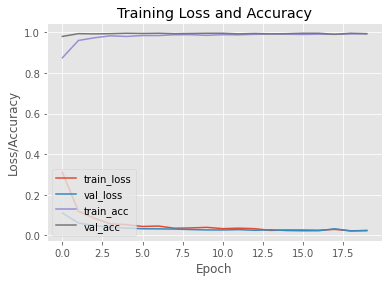

In [21]:
# plot the training loss and accuracy

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Save and export model

In [22]:
# Save the model

MODEL_PATH = "../models/face_mask_detector.h5"
model.save(MODEL_PATH, save_format="h5")

In [30]:
pip install tensorflowjs==2.0.1

ERROR: -ensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: -ensorflow 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 2.2.1 which is incompatible.
ERROR: -ensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 2.3.0rc0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.3.0rc0 which is incompatible.
ERROR: rasa 1.4.3 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: rasa 1.4.3 has requirement gevent~=1.4, but you'll have gevent 20.6.2 which is incompatible.
ERROR: rasa 1.4.3 has requirement jsonschema~=2.6, but you'll have jsonschema 3.2.0 which is incompatible.
ERROR: rasa 1.4.3 has requirement networkx~=2.3.0, but you'll have networkx 2.4 which is incompatible.
ERROR: rasa 1.4.3 has requirement packaging~=19.0, but you'll have packag

  Using cached prompt_toolkit-1.0.14-py3-none-any.whl (248 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.5
    Uninstalling prompt-toolkit-3.0.5:
      Successfully uninstalled prompt-toolkit-3.0.5
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0


In [ ]:
pip uninstall tensorflow_estimator

In [ ]:
pip install tensorflow_estimator

In [ ]:
# Export into TensorFlow.js

import tensorflowjs as tfjs

TFJS_MODEL_DIR = "../models/tfjs"
tfjs.converters.save_keras_model(model, TFJS_MODEL_DIR)